[[ 1.  1.  0. ...,  1.  1.  1.]
 [ 0.  0.  0. ...,  1.  0.  1.]
 [ 1.  1.  0. ...,  0.  1.  1.]
 ..., 
 [ 1.  0.  1. ...,  1.  0.  0.]
 [ 1.  1.  1. ...,  0.  0.  0.]
 [ 1.  1.  0. ...,  1.  1.  0.]]


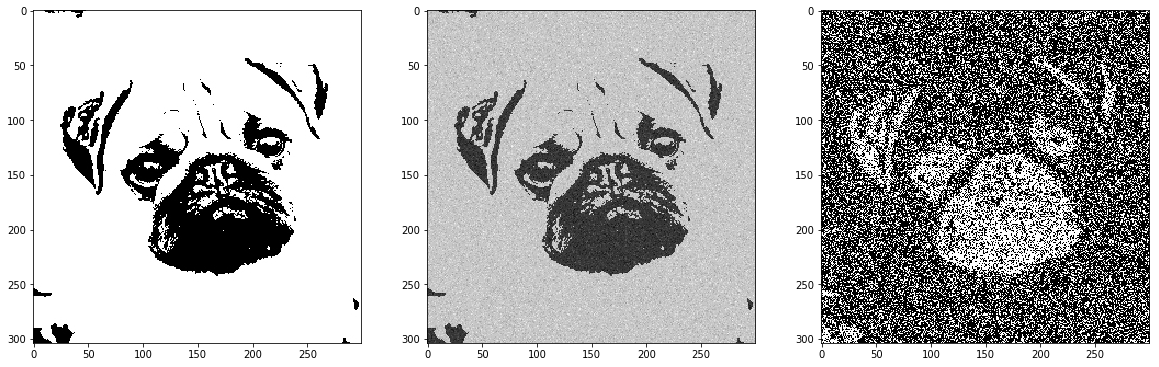

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.misc import imread

def add_gaussian_noise(im,prop,varSigma):
    N = int(np.round(np.prod(im.shape)*prop))
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    e = varSigma*np.random.randn(np.prod(im.shape)).reshape(im.shape)
    im2 = np.copy(im).astype('float')
    im2[index] += e[index]
    return im2

def add_saltnpeppar_noise(im,prop):
    N = int(np.round(np.prod(im.shape)*prop))
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    im2 = np.copy(im)
    im2[index] = 1-im2[index]
    return im2

# proportion of pixels to alter
prop = 0.7
varSigma = 0.1

im = imread('newPug.jpg')
im = im/255

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(131)
ax.imshow(im,cmap='gray')

im2 = add_gaussian_noise(im,prop,varSigma)
ax2 = fig.add_subplot(132)
ax2.imshow(im2,cmap='gray')

im3 = add_saltnpeppar_noise(im,prop)
print(im3)
ax3 = fig.add_subplot(133)
ax3.imshow(im3,cmap='gray')



In [41]:
def neighbours(i,j,M,N,size=4):
    if size==4:
        if (i==0 and j==0):
            n=[(0,1), (1,0)]
        elif i==0 and j==N-1:
            n=[(0,N-2), (1,N-1)]
        elif i==M-1 and j==0:
            n=[(M-1,1), (M-2,0)]
        elif i==M-1 and j==N-1:
            n=[(M-1,N-2), (M-2,N-1)]
        elif i==0:
            n=[(0,j-1), (0,j+1), (1,j)]
        elif i==M-1:
            n=[(M-1,j-1), (M-1,j+1), (M-2,j)]
        elif j==0:
            n=[(i-1,0), (i+1,0), (i,1)]
        elif j==N-1:
            n=[(i-1,N-1), (i+1,N-1), (i,N-2)]
        else:
            n=[(i-1,j), (i+1,j), (i,j-1), (i,j+1)]
        return n
    
    if size==8:
        print('Not yet implemented\n')
    return -1


Passes complete:  50


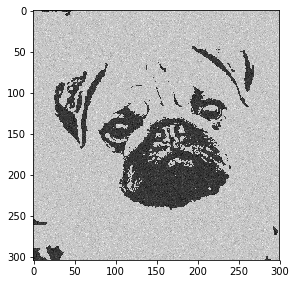

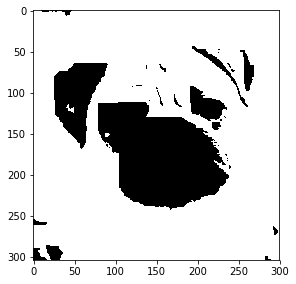

In [172]:
def Li(xi, yi, beta):
    return - (beta * (xi - (2 * yi - 1))**2)

def likelihood(func, noise_im, x_im, i, j, beta):
    l = func(x_im[i][j], noise_im[i][j], beta)
    return l

def prior(w, noise_image, i, j):
    sum = 0
    for neighbour in neighbours(i, j, noise_image.shape[0], noise_image.shape[1]):
        sum = sum + (noise_image[neighbour] * noise_image[i][j])
    return sum * w

def joint(func, noise_image, x_im, i, j, w, beta):
    return prior(w, x_im, i, j) + likelihood(func, noise_image, x_im, i, j, beta)

def icmSinglePass(func, noise_image, latent_image, w, beta):
    testForOne = np.copy(latent_image)
    testForNegOne = np.copy(latent_image)
    output_image = np.copy(latent_image)
    for i in range(noise_image.shape[0]):
        for j in range(noise_image.shape[1]):
            initial = output_image[i][j]
            testForOne[i][j] = 1.0
            testForNegOne[i][j] = -1.0

            energyForOne = joint(func, latent_image, testForOne, i, j, w, beta)
            energyForNegOne = joint(func, latent_image, testForNegOne, i, j, w, beta)

            # print(i, j, energyForOne, energyForNegOne, initial)

            if energyForOne > energyForNegOne:
                output_image[i][j] = 1.0
                testForOne[i][j] = 1.0
            else:
                output_image[i][j] = -1.0
                testForNegOne[i][j] = -1.0
            
    return output_image

def showImage(img, size):
    fig = plt.figure(figsize=(size,size))
    ax = fig.add_subplot(131)
    ax.imshow(img,cmap='gray')

def icmMultiplePass(func, noise_image, latent_image, w, beta, T):
    if T is 0:
        return (noise_image, 0)

    change = False
    result = icmSinglePass(func, noise_image, latent_image, w, beta)

    if (T==1):
        showImage(result, 15)

    for i in range(noise_image.shape[0]):
        for j in range(noise_image.shape[1]):
            if result[i][j] != latent_image[i][j]:
                change = True

    if change is False:
        return (result, T)

    return icmMultiplePass(func, noise_image, result, w, beta, T - 1)


passes = 50
showImage(im2, 15)
icm = icmMultiplePass(Li, im2, im2, 1, 1, passes)

print("Passes complete: ", (passes - icm[1]))


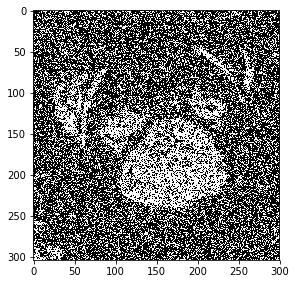

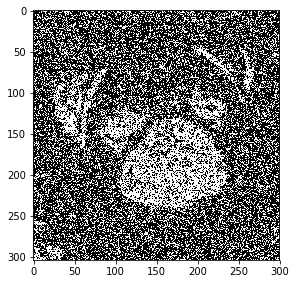

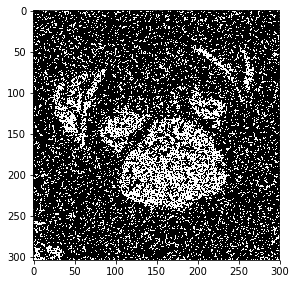

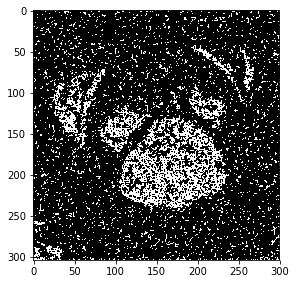

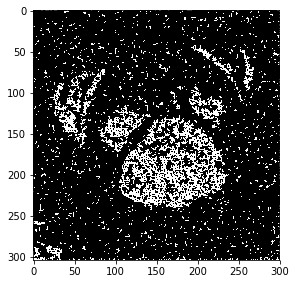

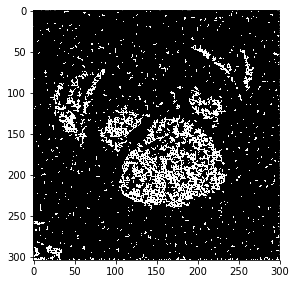

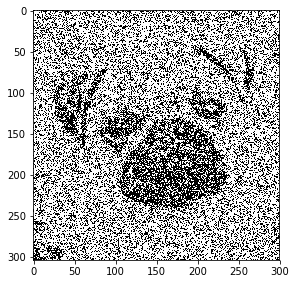

In [156]:

def Li_salty(xi, yi, beta):
    return beta * (xi - (-2*yi+1))**2

passes = 5
showImage(im3, 15)
newIm3 = im3
beta = 3
icm, t = icmMultiplePass(Li_salty, im3, im3, 1, 1, passes)
showImage(1-icm, 15)

C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


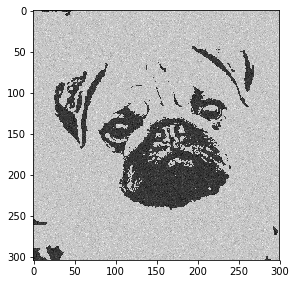

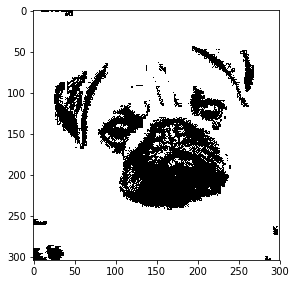

In [167]:
def singleLikelihood(func, noisy_image, x_i, row, col, beta):
    return np.exp(func(x_i, noisy_image[row][col], beta))

def singlePrior(w, x_i, latent_image, i, j):
    sum = 0
    for neighbour in neighbours(i, j, latent_image.shape[0], latent_image.shape[1]):
        sum = sum + (x_i * latent_image[neighbour])
    return sum * w

def singlePosterior(func, noisy_image, latent_image, row, col, w, beta):
    A = singlePrior(w, 1, latent_image, row, col) * singleLikelihood(func, noisy_image, 1, row, col, beta)
    B = singlePrior(w, -1, latent_image, row, col) * singleLikelihood(func, noisy_image, -1, row, col, beta)
    posterior = A / (A+B)
    return posterior

def singleGibbsSamplePass(func, noise_image, initialization, w, beta):
    x_0 = np.copy(initialization)
    for row in range(x_0.shape[0]):
        for col in range(x_0.shape[1]):
            p_i = singlePosterior(func, noise_image, x_0, row, col, w, beta)
            t = np.random.uniform(0,1)
            z = 1 if (p_i > t) else -1
            x_0[row][col] = z
    return x_0;

def gibbsSample(func, noise_image, iters, w, beta):
    showImage(noise_image, 15)
    
    if (iters == 0):
        return
    
    gibbsPass = singleGibbsSamplePass(func, noise_image, noise_image, w, beta) 
    #showImage(gibbsPass, 15)
    
    if (iters > 1):
        for i in range(iters-1):
            gibbsPass = singleGibbsSamplePass(func, noise_image, gibbsPass, w, beta)
            #showImage(gibbsPass, 15)
    return gibbsPass

w = 1
beta = 1
#gibbsSample(Li, im2, 10, w, beta)
g = gibbsSample(Li, im2, 50, w, beta)
showImage(g, 15)

C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


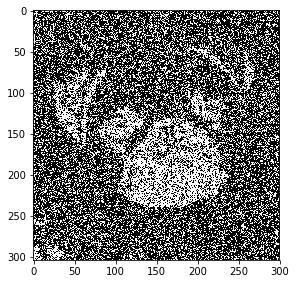

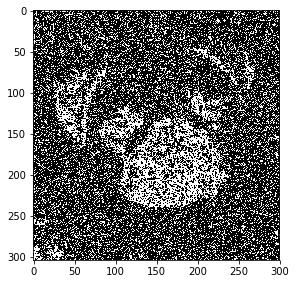

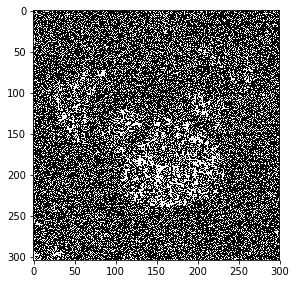

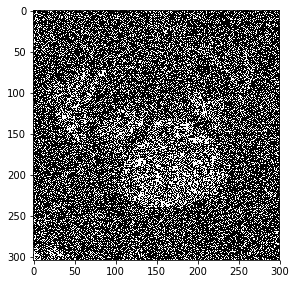

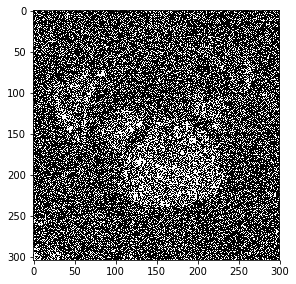

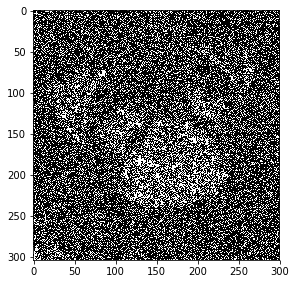

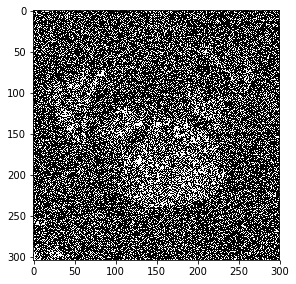

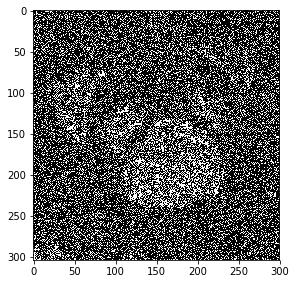

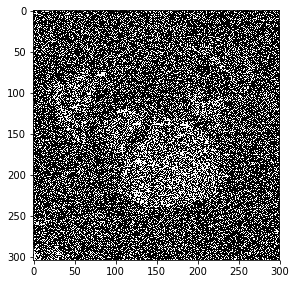

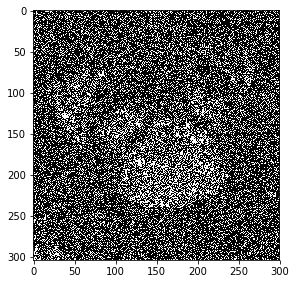

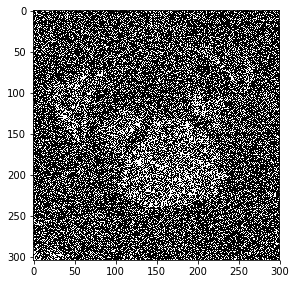

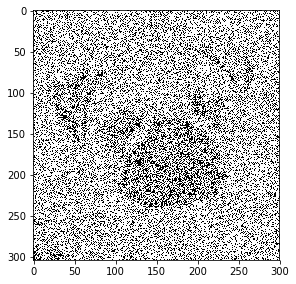

In [59]:
def Li_salty(xi, yi, beta):
    return beta * (xi - (-2*yi+1))**2

beta = 1
im = gibbsSample(Li_salty, im3, 10, w, beta)
showImage(np.multiply(-1,im), 15)

C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


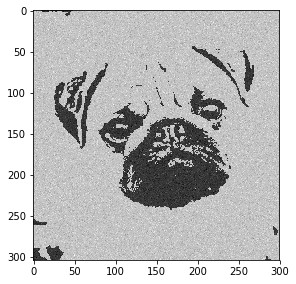

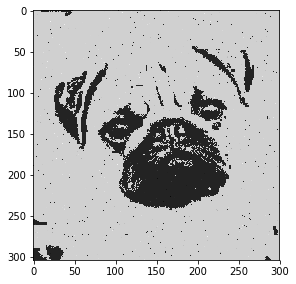

In [48]:
def singleRandomGibbsSamplePass(noise_image, initialization, w, beta):
    x_0 = np.copy(initialization)
    for i in range(x_0.shape[0]*x_0.shape[1]):
        row = np.random.randint(0, x_0.shape[0])
        col = np.random.randint(0, x_0.shape[1])
            
        p_i = singlePosterior(Li, noise_image, x_0, row, col, w, beta)
        t = np.random.uniform(0,1)
        z = 1 if (p_i > t) else -1
        x_0[row][col] = z
    return x_0;

def randomGibbsSample(noise_image, iters, w, beta):
    
    if (iters == 0):
        return
    
    gibbsPass = singleRandomGibbsSamplePass(noise_image, noise_image, w, beta) 
    
    if (iters > 1):
        for i in range(iters-1):
            gibbsPass = singleRandomGibbsSamplePass(noise_image, gibbsPass, w, beta)
    
    showImage(gibbsPass, 15)
    return


np.random.seed(42)
w = 1
beta = 5
showImage(newIm2, 15)
randomGibbsSample(newIm2, 5, w, beta)

C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


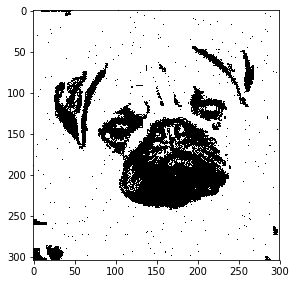

In [49]:
np.random.seed(42)
randomGibbsSample(newIm2, 10, w, beta)

C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


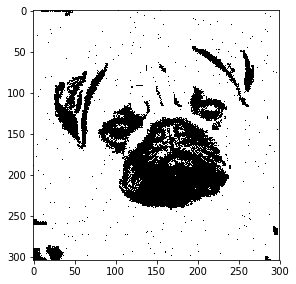

In [50]:
np.random.seed(42)
randomGibbsSample(newIm2, 20, w, beta)

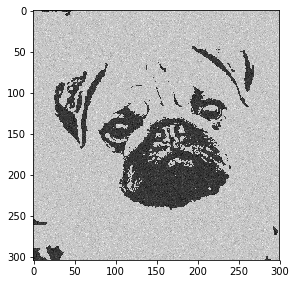

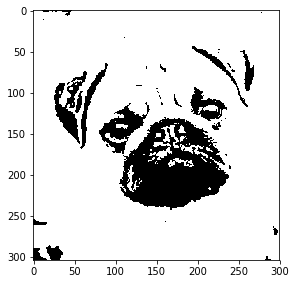

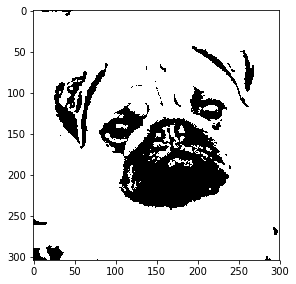

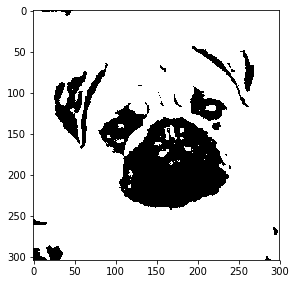

In [164]:
def a_i(m_i, y_i, beta):
    a = m_i + 0.5 * Li(1, y_i, beta) - 0.5 * Li(-1, y_i, beta)
    return a

def q_i(x_i, m_i, y_i, beta):
    exponent = -2 * a_i(m_i, y_i, beta)
    if (x_i == -1):
        exponent = -1 * exponent
        
    q = 1 / (1 + np.exp(exponent))
    return q

def q(x, m, y, beta):
    out = np.copy(m)
    for row in range(out.shape[0]):
        for col in range(out.shape[1]):
            x_i = x[row][col]
            m_i = m[row][col]
            y_i = y[row][col]
            out[row][col] = q_i(x_i, m_i, y_i, beta)
    return out

def m_i_next(w, mu, i, j):
    sum = 0
    for neighbour in neighbours(i, j, mu.shape[0], mu.shape[1]):
        sum = sum + mu[neighbour]
    return sum * w

def mu_i_next(m_i, y_i, beta):
    arg = m_i + 0.5 * Li(1, y_i, beta)
    return np.tanh(arg)

def variationalBayes(x_img, noisy_img, w, beta, iters):
    m = np.copy(x_img)
    mu = np.copy(x_img)
    
    for i in range(iters):
        for row in range(x_img.shape[0]):
            for col in range(x_img.shape[1]):
                m_i = m_i_next(w, mu, row, col)     # compute parameter
                mu_i = mu_i_next(m[row][col], noisy_img[row][col], beta)

                # update
                m[row][col] = m_i
                mu[row][col] = mu_i
    
    end_img = np.copy(x_img)
    for row in range(x_img.shape[0]):
            for col in range(x_img.shape[1]):
                m_i = m[row][col]
                y_i = noisy_img[row][col]
                approx_post = q_i(1, m_i, y_i, beta)
                
                t = np.random.uniform(0,1)
                z = 1 if (approx_post > t) else -1
                end_img[row][col] = z
    showImage(end_img, 15)
    return
    

w = 1
beta = 1
showImage(im2, 15)
out = variationalBayes(im2, im2, w, beta, 1)
out = variationalBayes(im2, im2, w, beta, 3)
out = variationalBayes(im2, im2, w, beta, 50)

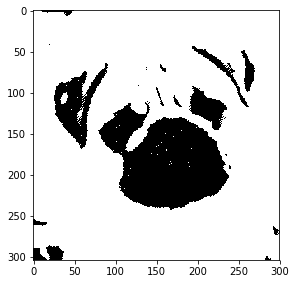

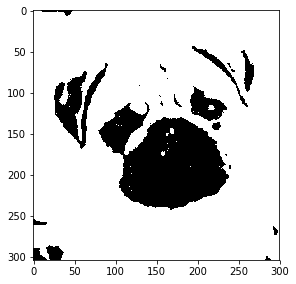

In [165]:
out = variationalBayes(im3, im2, w, beta, 50)
out = variationalBayes(np.ones(im2.shape), im2, w, beta, 50)

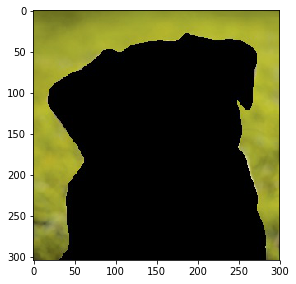

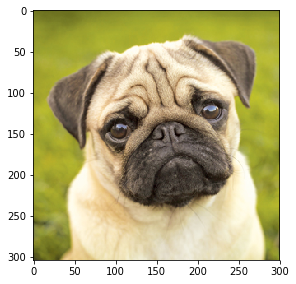

In [125]:
def showImageColor(img, size):
    fig = plt.figure(figsize=(size,size))
    ax = fig.add_subplot(131)
    ax.imshow(img)

mask_im = imread('pugFaceMask.jpg')
actual_im = imread('pugFace.jpg')
showImageColor(mask_im,15)
showImageColor(actual_im,15)

foreground_r_data = []
foreground_g_data = []
foreground_b_data = []

background_r_data = []
background_g_data = []
background_b_data = []

foreground_data = []
background_data = []

for row in range(actual_im.shape[0]):
    for col in range(actual_im.shape[1]):
        if (mask_im[row][col][0] == 0 and mask_im[row][col][1] == 0 and mask_im[row][col][2] == 0):
            foreground_r_data.append(actual_im[row][col][0])
            foreground_g_data.append(actual_im[row][col][1])
            foreground_b_data.append(actual_im[row][col][2])
            foreground_data.append(actual_im[row][col])
        else:
            background_r_data.append(actual_im[row][col][0])
            background_g_data.append(actual_im[row][col][1])
            background_b_data.append(actual_im[row][col][2])
            background_data.append(actual_im[row][col])

foreground_density, [foreground_r_bins, foreground_g_bins, foreground_b_bins] = np.histogramdd((foreground_r_data,foreground_g_data,foreground_b_data), bins = (255, 255, 255), normed=True)
background_density, [background_r_bins, background_g_bins, background_b_bins] = np.histogramdd((background_r_data,background_g_data,background_b_data), bins = (255, 255, 255), normed=True)

C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


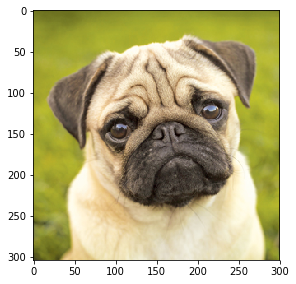

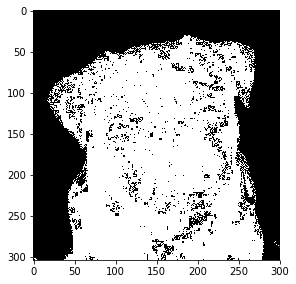

In [178]:
def Li_segmentation(xi, yi, beta):
    if (xi == 1): ##likelihood that pixel is from foreground.
        r_index = np.digitize(yi[0], foreground_r_bins)-2
        g_index = np.digitize(yi[1], foreground_g_bins)-2
        b_index = np.digitize(yi[2], foreground_b_bins)-2
        l_i = foreground_density[r_index][g_index][b_index]
        return np.log(l_i)
    else:
        r_index = np.digitize(yi[0], background_r_bins)-2
        g_index = np.digitize(yi[1], background_g_bins)-2
        b_index = np.digitize(yi[2], background_b_bins)-2
        l_i = background_density[r_index][g_index][b_index]
        return np.log(l_i)

def singlePosterior(func, noisy_image, latent_image, row, col, w, beta):
    A = singlePrior(w, 1, latent_image, row, col) * singleLikelihood(func, noisy_image, 1, row, col, beta)
    B = singlePrior(w, -1, latent_image, row, col) * singleLikelihood(func, noisy_image, -1, row, col, beta)
    posterior = A / (A+B)
    return posterior
    
def singleGibbsSamplePass(func, noise_image, initialization, w, beta):
    x_0 = np.copy(initialization)
    for row in range(x_0.shape[0]):
        for col in range(x_0.shape[1]):
            p_i = singlePosterior(func, noise_image, x_0, row, col, w, beta)
            t = np.random.uniform(0,1)
            z = 1 if (p_i > t) else -1
            x_0[row][col] = z
    return x_0;  

def gibbsSample(func, noise_image, iters, w, beta):
    showImage(noise_image, 15)
    
    if (iters == 0):
        return
    
    gibbsPass = singleGibbsSamplePass(func, noise_image, im2, w, beta) 
    #showImage(gibbsPass, 15)
    
    if (iters > 1):
        for i in range(iters-1):
            gibbsPass = singleGibbsSamplePass(func, noise_image, gibbsPass, w, beta)
            # showImage(gibbsPass, 15)
    return gibbsPass

w = 1
beta = 1
g = gibbsSample(Li_segmentation, actual_im, 50, w, beta)
showImage(g, 15)

C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ..., 
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]])

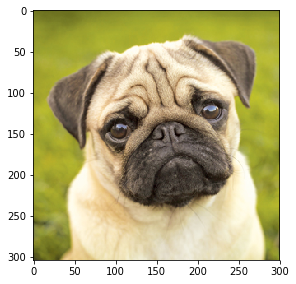

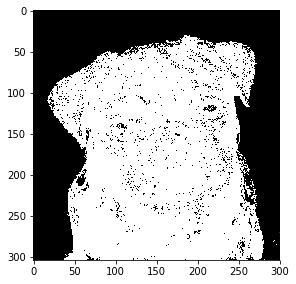

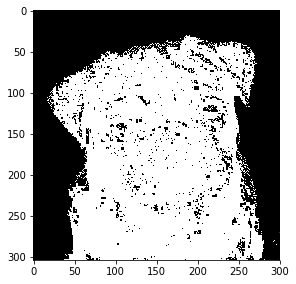

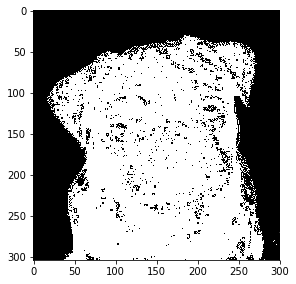

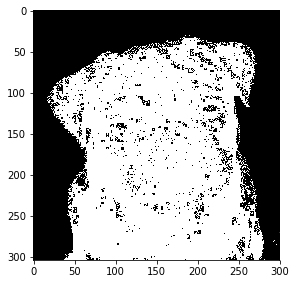

In [174]:
foreground_density, [foreground_r_bins, foreground_g_bins, foreground_b_bins] = np.histogramdd((foreground_r_data,foreground_g_data,foreground_b_data), bins = (51, 51, 51), normed=True)
background_density, [background_r_bins, background_g_bins, background_b_bins] = np.histogramdd((background_r_data,background_g_data,background_b_data), bins = (51, 51, 51), normed=True)
gibbsSample(Li_segmentation, actual_im, 4, w, beta)

C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ..., 
       [ 1., -1., -1., ..., -1., -1., -1.],
       [-1.,  1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]])

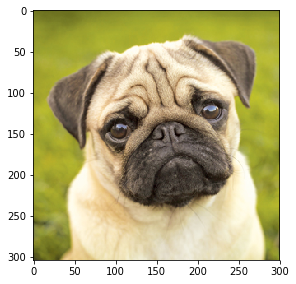

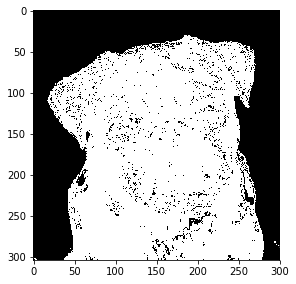

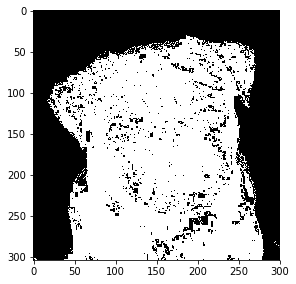

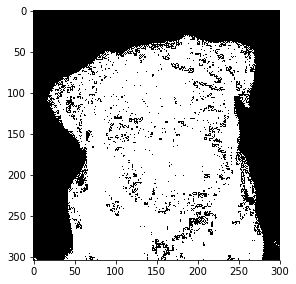

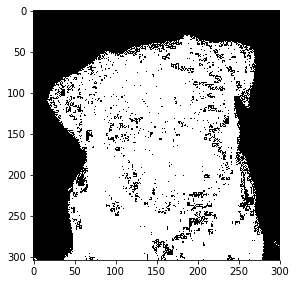

In [175]:
foreground_density, [foreground_r_bins, foreground_g_bins, foreground_b_bins] = np.histogramdd((foreground_r_data,foreground_g_data,foreground_b_data), bins = (26, 26, 26), normed=True)
background_density, [background_r_bins, background_g_bins, background_b_bins] = np.histogramdd((background_r_data,background_g_data,background_b_data), bins = (26, 26, 26), normed=True)
gibbsSample(Li_segmentation, actual_im, 4, w, beta)